# “图检文” 任务 预处理

基于文本检索的模型和算法，利用附件 3 中“image_test.csv”文件提及的图像ID，

对附件 3 的“word_data.csv”文件进行文本检索，并罗列检索相似度较高的前五条文本，

将结果存放在“result2.csv”文件中（模板文件见附件 4 的 result2.csv）。

其中，“image_test.csv”文件提及的图像 id，对应的图像数据可在附件 3 的 ImageData 文件夹中获取

In [1]:
from PIL import Image
from io import BytesIO
import base64
import pandas as pd 
import numpy as np
import re  
import os  
import base64  
import csv

In [2]:
Path_ =  r"D:/2024tdb/B/B题-示例数据/示例数据/附件3/"     ##附件s三文件夹路径
Path_img = r"D:/2024tdb/B/B题-示例数据/示例数据/附件3/ImageData"  ##附件三 ImageData文件夹路径
Path_image_test_csv = r"D:/2024tdb/B/B题-示例数据/示例数据/附件3/image_test.csv"  ##附件二 image_test.csv路径
Path_word_data_csv = r"D:/2024tdb/B/B题-示例数据/示例数据/附件3/word_data.csv"  ##附件二 word_data.csv"路径

## 生成附件3的ImageData文件夹图片的模型数据

In [3]:

##图片转为base64：
def img2base64(img_path):
    img = Image.open(img_path) # 访问图片路径
    img_buffer = BytesIO()
    img.save(img_buffer, format=img.format)
    byte_data = img_buffer.getvalue()
    base64_str = base64.b64encode(byte_data) # bytes
    base64_str = base64_str.decode("utf-8") # str
    return base64_str

In [4]:
## 读取图片对应的image_test.csv进行，图片id新生成对应表，以及图片clip模型数据：

df = pd.read_csv(Path_image_test_csv,encoding='utf-8') 
df 

new_image_ids = []
for image_id in df['image_id']:
    s = image_id.replace('-',"")
    new_image_id = re.findall(r'\d+', s)[0] 
    new_image_ids.append(new_image_id)
df['new_image_id'] = new_image_ids
df 
df.to_csv("任务三image_id对照表.csv",encoding='utf-8',index=False)

In [5]:
def creat_clipdata(df, ImageData_PATH, task):
     with open(f"{task}_imgs.tsv", 'w', newline='',encoding='utf-8') as tsvfile:
        tsvwriter = csv.writer(tsvfile, delimiter='\t')
        for index, row in df.iterrows():
            imgpath = os.path.join(ImageData_PATH,row['image_id'])
            b64img = img2base64(imgpath)
            tsvwriter.writerow([row['new_image_id'],b64img])
        tsvfile.close()

In [6]:
##生成待预测的图片的模型数据：
creat_clipdata(df=df, ImageData_PATH=Path_img, task="predict2")

## 生成附件3的文本的模型数据

In [10]:
## 读取文本对应的word_data_csv.csv进行，文本id新生成对应表，以及文本clip模型数据：


df = pd.read_csv(Path_word_data_csv, encoding="gb18030") 
new_text_ids = []
for text_id in df['text_id']:
    s = text_id.replace('-',"")
    new_text_id = re.findall(r'\d+', s)[0] 
    new_text_ids.append(new_text_id)
df['new_text_id'] = new_text_ids
df 

,text_id,caption,new_text_id
0,Word-1000050041,"吞下委屈,才能喂大格局",1000050041
1,Word-1000050124,"于是就出现了一个话题,就是娱乐圈的大叔们越来越胖,和香港男人形成",1000050124
2,Word-1000050258,ic小禾新款polo领撞色条纹宽松针织短袖t恤,1000050258
3,Word-1000050272,奇葩说第五季颜如晶再度错失bbking 陈铭赢在哪里?,1000050272
4,Word-1000050310,竞争激烈国产第6款pd1即将获批来自誉衡药业药明生物,1000050310
...,...,...,...
995,Word-1000099625,"都什么年代了,为什么军队不许左撇子扔手榴弹?",1000099625
996,Word-1000099707,中国女乒顺利交接男乒不清晰马龙大蟒还想打年轻队员还要等,1000099707
997,Word-1000099785,尊师重道代代延续.,1000099785
998,Word-1000099789,这次行动就是对此类违法活动的一次排查与打击.,1000099789


In [13]:
import re 
def clear_txt(sent):
    org_sent = sent
    clear_words = ["<人名>","《","》","【","】","→",":","—"]
    pattern = re.compile(r'【(.*?)】|《(.*?)》|“(.*?)”', re.DOTALL)
    # 查找所有匹配项  
    matches = pattern.findall(sent)  
    # 整理匹配结果  
    resultskeys = []  
    for match in matches:  
        for group in match:  
            if group:  
                resultskeys.append(group)   ##第一次处理后关键词
                
    for cw in clear_words:
        if cw in sent:
            sent = sent.replace(cw," ")  ##第二次处理后sent
    sent2 = sent
    
    for key in resultskeys:
        sent = sent.replace(key,"")
    sent_dropkey = sent
            
    return org_sent, resultskeys,sent2, sent_dropkey

import jionlp as jio
def jionlp_keys(text):
    key_phrases = jio.keyphrase.extract_keyphrase(top_k=3,func_word_num=2,strict_pos=True,text=text)
    return key_phrases


In [14]:
new_caption = []
for sent in df["caption"]:
    if len(sent) < 15:
        new_caption.append(sent)
    else:
        key_list =[]
        org_sent, resultskeys,sent2, sent_dropkey = clear_txt(sent)
        if len(resultskeys) >0:
            for key in resultskeys:
                key_list.append(key)
        for v1 in jionlp_keys(sent2):
            if v1 not in key_list:
                key_list.append(v1)
        
        for v2 in jionlp_keys(sent_dropkey):
            if v2 not in key_list:
                key_list.append(v2)
        
        new_sent = ""
        for kw in key_list:
            new_sent=new_sent+kw+' '
        
        new_caption.append(new_sent)
        
new_caption
df['new_caption'] = new_caption
df

,text_id,caption,new_text_id,new_caption
0,Word-1000050041,"吞下委屈,才能喂大格局",1000050041,"吞下委屈,才能喂大格局"
1,Word-1000050124,"于是就出现了一个话题,就是娱乐圈的大叔们越来越胖,和香港男人形成",1000050124,香港男人 大叔们 娱乐圈
2,Word-1000050258,ic小禾新款polo领撞色条纹宽松针织短袖t恤,1000050258,撞色条纹宽松针织短袖t恤 ic 新款polo
3,Word-1000050272,奇葩说第五季颜如晶再度错失bbking 陈铭赢在哪里?,1000050272,晶 奇葩 陈铭
4,Word-1000050310,竞争激烈国产第6款pd1即将获批来自誉衡药业药明生物,1000050310,誉衡药业药明生物 pd1
...,...,...,...,...
995,Word-1000099625,"都什么年代了,为什么军队不许左撇子扔手榴弹?",1000099625,手榴弹 撇子 军队
996,Word-1000099707,中国女乒顺利交接男乒不清晰马龙大蟒还想打年轻队员还要等,1000099707,男乒 中国女乒 年轻队员
997,Word-1000099785,尊师重道代代延续.,1000099785,尊师重道代代延续.
998,Word-1000099789,这次行动就是对此类违法活动的一次排查与打击.,1000099789,违法活动 行动


In [15]:
df.to_csv("任务三text_id对照表.csv",encoding='utf-8',index=False)

In [16]:
def creat_clipdata(df, task):
    with open(f"{task}_texts.jsonl", 'w', encoding='utf-8') as jsonlfile:
        for index, row in df.iterrows():
            dict_jsonl = {}
            dict_jsonl['text_id'] = int(row['new_text_id'])
            dict_jsonl['text'] = row['new_caption']
            dict_jsonl['image_ids'] = []    ###任务为test时删除  int(row['new_image_id'])
            jsonlfile.write(json.dumps(dict_jsonl)+'\n')

In [17]:
##生成待预测的文本的模型数据：
creat_clipdata(df=df, task="predict2")

# 后处理

In [7]:
import json
from PIL import Image
from io import BytesIO
import base64
import pandas as pd 
import numpy as np
import re  
import os  
import base64  
import csv
from PIL import Image  
import matplotlib.pyplot as plt  
import os  


Bad key "text.kerning_factor" on line 4 in
C:\Users\X\.conda\envs\Pytorch_GPU\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [8]:
Path_img = r"D:/2024tdb/B/B题-示例数据/示例数据/附件3/ImageData"  ##附件三 ImageData文件夹路径

img2text_result = r"./predict2_img2txt.jsonl"   ###图片预测文本的结果

In [9]:
## 读取结果jsonl
with open(img2text_result, 'r', encoding="utf-8") as f:
    for index,line in enumerate(f):
        data = json.loads(line)
        print(data)

{'image_id': 140010139673, 'text_ids': [1000082155, 1000093145, 1000072779, 1000075349, 1000099425]}
{'image_id': 140010140314, 'text_ids': [1000097472, 1000058737, 1000092116, 1000054948, 1000057493]}
{'image_id': 140010143805, 'text_ids': [1000074505, 1000058302, 1000052265, 1000093552, 1000075335]}
{'image_id': 140010144177, 'text_ids': [1000084392, 1000062709, 1000078004, 1000072367, 1000057493]}
{'image_id': 140010144696, 'text_ids': [1000080829, 1000092132, 1000079685, 1000083190, 1000071033]}
{'image_id': 140010144902, 'text_ids': [1000098769, 1000066853, 1000086230, 1000056793, 1000089840]}
{'image_id': 140010145685, 'text_ids': [1000063611, 1000056708, 1000074505, 1000052265, 1000075384]}
{'image_id': 140010145858, 'text_ids': [1000088040, 1000052728, 1000099425, 1000083638, 1000080875]}
{'image_id': 140010146488, 'text_ids': [1000067733, 1000099521, 1000089997, 1000067079, 1000094197]}
{'image_id': 140010147394, 'text_ids': [1000095484, 1000084712, 1000077889, 1000060301, 100

### 展示图片预测文本结果

In [10]:
##加载 图片  文本的id对照表：
dfimg = pd.read_csv("./任务三image_id对照表.csv",encoding='utf-8') 
dfimg
dftext = pd.read_csv("./任务三text_id对照表.csv",encoding='utf-8') 
dftext
dfimg




,image_id,new_image_id
0,Image14001013-9673.jpg,140010139673
1,Image14001014-0314.jpg,140010140314
2,Image14001014-3805.jpg,140010143805
3,Image14001014-4177.jpg,140010144177
4,Image14001014-4696.jpg,140010144696
...,...,...
95,Image14105004-2021.jpg,141050042021
96,Image14105004-2874.jpg,141050042874
97,Image14105004-3983.jpg,141050043983
98,Image14105004-5128.jpg,141050045128


In [11]:
#duiyin对应键值对：

textid_dict = {k:v for k, v in zip(dftext['new_text_id'], dftext['text_id'])}
textid_dict

textid2txt_dict = {k:v for k, v in zip(dftext['new_text_id'],dftext['caption'] )}
textid2txt_dict

imgid_dict = {k:v for k, v in zip( dfimg['new_image_id'], dfimg['image_id'])}
imgid_dict

# textid2txt_dict

{140010139673: 'Image14001013-9673.jpg',
 140010140314: 'Image14001014-0314.jpg',
 140010143805: 'Image14001014-3805.jpg',
 140010144177: 'Image14001014-4177.jpg',
 140010144696: 'Image14001014-4696.jpg',
 140010144902: 'Image14001014-4902.jpg',
 140010145685: 'Image14001014-5685.jpg',
 140010145858: 'Image14001014-5858.jpg',
 140010146488: 'Image14001014-6488.jpg',
 140010147394: 'Image14001014-7394.jpg',
 140010147492: 'Image14001014-7492.jpg',
 140010148012: 'Image14001014-8012.jpg',
 140010148069: 'Image14001014-8069.jpg',
 140010148266: 'Image14001014-8266.jpg',
 140010148324: 'Image14001014-8324.jpg',
 140010148696: 'Image14001014-8696.jpg',
 140010148840: 'Image14001014-8840.jpg',
 140010149805: 'Image14001014-9805.jpg',
 140010150009: 'Image14001015-0009.jpg',
 140010151289: 'Image14001015-1289.jpg',
 140010151650: 'Image14001015-1650.jpg',
 140010152299: 'Image14001015-2299.jpg',
 140010152621: 'Image14001015-2621.jpg',
 140010152902: 'Image14001015-2902.jpg',
 140010153145: '

In [12]:
def show_img2txt(ditc_):
    ##输出一张图片：
    # 打开图片  
    img_name = imgid_dict[ditc_['image_id']]
    print(img_name)
    img_path = os.path.join(Path_img, img_name)
    print(img_path)
    img = Image.open(img_path)  
    # 显示图片  
    # 显示图片，注意这里需要使用plt的imshow函数  
    plt.imshow(img)  

    # 设置x和y轴的标签为空，防止在图片上显示刻度  
    plt.xticks([])  
    plt.yticks([])  

    # 显示图片窗口  
    plt.show()
    
    
    ##显示该图片对应的5个预测结果text：
    for t in ditc_['text_ids']:
        print(textid2txt_dict[t])
    

Image14105002-9595.jpg
D:/2024tdb/B/B题-示例数据/示例数据/附件3/ImageData\Image14105002-9595.jpg


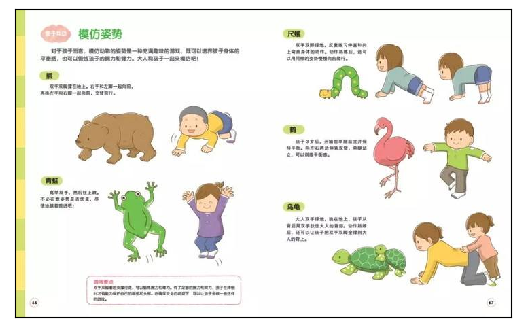

小学生一定要做的思维拓展题 高级阶段1~3年级 小学生
会指导新手爸妈如何通过亲密的互动促进宝宝大脑发育.
2020年普陀区幼儿入园网上报名即将开始!手把手教你如何操作
对于大部分家长来说,脑袋里剩下的知识已经很难满足辅导孩子课程的
和女孩子聊天怎么才不会聊死,高情商的男生都是这样做


In [13]:
di = {'image_id': 140010139673, 'text_ids': [1000082155, 1000093145, 1000072779, 1000075349, 1000099425]}
di2 = {'image_id': 140010146488, 'text_ids': [1000067733, 1000099521, 1000089997, 1000067079, 1000094197]}
di3 = {'image_id': 141050029595, 'text_ids': [1000074658, 1000098098, 1000059124, 1000070127, 1000079426]}
show_img2txt(di3)

### 整理结果 导出为 result2.csv

In [14]:
## 读取结果jsonl
image_id = []
similarity_ranking =[]
result_text_id = []

with open(img2text_result, 'r', encoding="utf-8") as f:
    for index,line in enumerate(f):
        data = json.loads(line)
#         print(data)
        for index,v in enumerate(data['text_ids']):
            image_id.append(imgid_dict[data['image_id']])
            similarity_ranking.append(index+1)
            result_text_id.append(textid_dict[v])
        
result2_data = {  
    'image_id': image_id,  
    'similarity_ranking':similarity_ranking,  
    'result_text_id': result_text_id
}  
  
# 使用pd.DataFrame()函数创建DataFrame  
result2_df = pd.DataFrame(result2_data)  
  
# 显示DataFrame的内容  
result2_df

,image_id,similarity_ranking,result_text_id
0,Image14001013-9673.jpg,1,Word-1000082155
1,Image14001013-9673.jpg,2,Word-1000093145
2,Image14001013-9673.jpg,3,Word-1000072779
3,Image14001013-9673.jpg,4,Word-1000075349
4,Image14001013-9673.jpg,5,Word-1000099425
...,...,...,...
495,Image14105004-6316.jpg,1,Word-1000060320
496,Image14105004-6316.jpg,2,Word-1000068387
497,Image14105004-6316.jpg,3,Word-1000089840
498,Image14105004-6316.jpg,4,Word-1000080875


In [15]:
# 使用自定义函数来处理 text_id 列  
def custom_text_id(group):  
    # 仅在第一行保留 text_id，其余行留空  
    group.iloc[0, group.columns.get_loc('image_id')] = group.iloc[0, group.columns.get_loc('image_id')]  
    group.iloc[1:, group.columns.get_loc('image_id')] = ''  
    return group  

# 按 text_id 分组并应用自定义函数  
result = result2_df.groupby('image_id', as_index=False, sort=False).apply(custom_text_id).reset_index(drop=True)  
result

C:\Users\X\AppData\Local\Temp\ipykernel_12452\705999972.py:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  result = result2_df.groupby('image_id', as_index=False, sort=False).apply(custom_text_id).reset_index(drop=True)


,image_id,similarity_ranking,result_text_id
0,Image14001013-9673.jpg,1,Word-1000082155
1,,2,Word-1000093145
2,,3,Word-1000072779
3,,4,Word-1000075349
4,,5,Word-1000099425
...,...,...,...
495,Image14105004-6316.jpg,1,Word-1000060320
496,,2,Word-1000068387
497,,3,Word-1000089840
498,,4,Word-1000080875


In [51]:
result.to_csv("result2.csv",encoding='utf-8',index=False)